# Prerequisites

In [ ]:
# connect to drive to retrieve dataset
from google.colab import drive
drive.mount('/content/gdrive') 
# don't forget to make a connection between the documents in the shared drive 
# and your own before uploading the documents to colab

In [ ]:
# necessary because upgraded version does not contain package for the model anymore
!pip install --upgrade gensim==3.8

# upgrade pandas for gensimvis
!pip install pandas==1.3.1

# install pyLDAvis
!pip install pyLDAvis

In [ ]:
# loading Mallet to Colab
# https://medium.com/analytics-vidhya/mallet-machine-learning-for-language-toolkit-installation-on-google-colaboratory-80b75fe486cb

# only need to run this once!!

import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  !java -version       #check java version
install_java()

In [ ]:
# check your documents before doing this multiple times
# !wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
# !unzip mallet-2.0.8.zip

In [ ]:
# not sure whether this was necessary
#import zipfile
#from google.colab import files

#uploaded = files.upload()

In [ ]:
# define path to mallet
os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet' # you should NOT need to change this 
corpus_path = 'transcripts' # you need to change this path to the directory containing your corpus of .txt files

# Topic Modelling

In [32]:
import pandas as pd

df = pd.read_csv('/content/gdrive/MyDrive/music_videos_v2.csv')
df.head()

,Unnamed: 0,song_id,song,year,artist,genre,lyrics,video_path
0,0,104799,holy,2016,florida-georgia-line,Country,When the sun had left and the winter came And ...,https://www.youtube.com/watch?v=zXDAYlhdkyg
1,1,96856,temporary-home,2009,carrie-underwood,Country,Little boy six years old A little too used to ...,https://www.youtube.com/watch?v=LraOiHUltak
2,2,200403,pistol,2007,dustin-kensrue,Country,Love how you curse when I wake you up Sweetly ...,https://www.youtube.com/watch?v=72D49j0RcPs
3,3,81046,summer,2016,cassadee-pope,Country,Verse 1 Rolled in as wild and free As a clear ...,https://www.youtube.com/watch?v=4w5K75KPIcQ
4,4,78479,little-moments,2010,brad-paisley,Country,Well I'll never forget the first time that I h...,https://www.youtube.com/watch?v=vBErCVNP6rM


## Tokenization

### NLTK

In [7]:
# NLTK/Pure Python
def tokenize(text):
    punctuations = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
    for punctuation in punctuations:
        text = text.replace(punctuation, '')
    text = text.lower() 
    text = text.split()
    return text

nltk_tokenized_texts = [tokenize(lyrics) for lyrics in df.lyrics]
print(nltk_tokenized_texts)

Output hidden; open in https://colab.research.google.com to view.

### Spacy

In [8]:
# Spacy
import spacy

nlp = spacy.load("en_core_web_sm")
processed_texts = [lyrics for lyrics in nlp.pipe(df.lyrics, 
                                              disable=["ner",
                                                       "parser"])]

# this part also removes stop words (I guess that may be undesired)
spacy_tokenized_texts_sw = [[word.text.lower() for word in processed_text if not word.is_stop] 
                      for processed_text in processed_texts]
print(spacy_tokenized_texts_sw)

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use sele

[['sun', 'left', 'winter', 'came', 'sky', 'fall', 'bring', 'rain', 'sat', 'darkness', 'broken', 'hearted', 'find', 'day', 'feel', 'meant', 'cry', 'started', 'losing', 'hope', 'baby', 'broke', 'saved', 'angel', 'tell', 'leaving', "'cause", 'thing', 'know', 'believe', 'holy', 'holy', 'holy', 'holy', 'high', 'loving', 'high', 'loving', 'holy', 'holy', 'holy', 'holy', 'high', 'loving', 'high', 'loving', 'brightest', 'days', 'darkest', 'nights', 'river', 'bank', 'baptized', 'cleanse', 'demons', 'killing', 'freedom', 'let', 'lay', 'ya', 'singing', 'babe', 'hallelujah', 'touching', 'touching', 'heaven', 'angel', 'tell', 'leaving', "'cause", 'thing', 'know', 'believe', 'holy', 'holy', 'holy', 'holy', 'high', 'loving', 'high', 'loving', 'holy', 'holy', 'holy', 'holy', 'high', 'loving', 'high', 'loving', 'need', 'stars', 'cause', 'shine', 'like', 'fire', 'veins', 'ecstasy', 'ecstasy', 'holy', 'holy', 'holy', 'holy', 'high', 'loving', 'high', 'loving', 'holy', 'holy', 'holy', 'holy', 'high', 'lov

## Vectorization

### NLTK

In [9]:
# nltk

from gensim.corpora import Dictionary

MIN_DF = 1 # minium document frequency
MAX_DF = 0.6 # maximum document frequency

nltk_dictionary = Dictionary(nltk_tokenized_texts) # get the vocabulary
nltk_dictionary.filter_extremes(no_below=MIN_DF, 
                           no_above=MAX_DF)
nltk_corpus = [nltk_dictionary.doc2bow(text) for text in nltk_tokenized_texts]

### Spacy

In [10]:
# spacy

spacy_dictionary = Dictionary(spacy_tokenized_texts_sw) # get the vocabulary
spacy_dictionary.filter_extremes(no_below=MIN_DF, 
                           no_above=MAX_DF)
spacy_corpus = [spacy_dictionary.doc2bow(text) for text in spacy_tokenized_texts_sw]

## Train the Model

In [15]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel
from gensim import similarities

import os.path
import re
import glob

import nltk
nltk.download('stopwords')

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

/usr/local/lib/python3.7/dist-packages/nltk/decorators.py:70: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  formatvalue=lambda value: "")[1:-1]
/usr/local/lib/python3.7/dist-packages/scipy/io/matlab/mio5.py:98: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from .mio5_utils import VarReader5


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### NLTK

In [ ]:
from gensim.models.wrappers import LdaMallet

N_TOPICS = 2 # k
N_ITERATIONS = 1000 # usually 1000 will do

nltk_lda = LdaMallet(mallet_path,
                corpus=nltk_corpus,
                id2word=nltk_dictionary,
                num_topics=N_TOPICS,
                optimize_interval=10,
                iterations=N_ITERATIONS)

### Spacy

In [17]:
from gensim.models.wrappers import LdaMallet

N_TOPICS = 2 # k
N_ITERATIONS = 1000 # usually 1000 will do

spacy_lda = LdaMallet(mallet_path,
                corpus=spacy_corpus,
                id2word=spacy_dictionary,
                num_topics=N_TOPICS,
                optimize_interval=10,
                iterations=N_ITERATIONS)

## Word Topic Distribution

### NLTK

In [ ]:
# words for the first topic:
TOPIC = 0
MAX_WORDS = 10
nltk_nltk_words = nltk_lda.show_topic(TOPIC, topn=MAX_WORDS) 
print(nltk_words)

In [ ]:
# word topic distribution in table
import pandas as pd

nltk_words = nltk_lda.show_topic(TOPIC, topn=len(spacy_dictionary)) # get all the words
nltk_topic_distr_df = pd.DataFrame(nltk_words, columns=['word', 'prop']) 
nltk_topic_distr_df.sort_values('prop', ascending=False).head()

In [ ]:
# loop through the number of topics
for topic in range(N_TOPICS):
    nltk_words = nltk_lda.show_topic(topic, 10)
    nltk_topic_n_words = ' '.join([word[0] for word in nltk_words])
    print('Topic {}: {}'.format(str(topic), nltk_topic_n_words))

In [ ]:
# vizualize one topic, we can use WordClouds:
import requests
import numpy as np
import matplotlib.pyplot as plt

from io import BytesIO
from PIL import Image
from wordcloud import WordCloud

TOPIC2PLOT = 1
MAX_WORDS = 80

def black_circle():
    response = requests.get('https://i.ibb.co/kHNWRYD/black-circle-better.png')
    circle_mask = np.array(Image.open(BytesIO(response.content)))
    return circle_mask 

circle_mask = black_circle()
wordcloud = WordCloud(background_color='#fff',
                      font_path='/content/gdrive/MyDrive/DIN Alternate Bold.otf',
                      color_func=lambda *args, **kwargs: (0,0,0),
                      mask=circle_mask)
wordcloud.generate_from_frequencies(frequencies=dict(nltk_lda.show_topic(TOPIC2PLOT, MAX_WORDS)))

plt.axis("off")
plt.imshow(wordcloud, interpolation="bilinear")

### Spacy

In [18]:
# words for the first topic:
TOPIC = 0
MAX_WORDS = 10
spacy_words = spacy_lda.show_topic(TOPIC, topn=MAX_WORDS) 
print(spacy_words)

[('love', 0.028171122354279557), ('time', 0.013232344400203575), ('na', 0.010523006915546508), ('feel', 0.00957997784630123), ('gon', 0.009205759961680089), ('life', 0.009086010238601323), ('wanna', 0.008996197946292249), ('yeah', 0.0077837320001197495), ('baby', 0.00757416998473191), ('good', 0.007155045953956231)]


In [19]:
# word topic distribution in table
import pandas as pd

spacy_words = spacy_lda.show_topic(TOPIC, topn=len(spacy_dictionary)) # get all the words
spacy_topic_distr_df = pd.DataFrame(spacy_words, columns=['word', 'prop']) 
spacy_topic_distr_df.sort_values('prop', ascending=False).head()

,word,prop
0,love,0.028171
1,time,0.013232
2,na,0.010523
3,feel,0.009580
4,gon,0.009206


In [20]:
# loop through the number of topics
for topic in range(N_TOPICS):
    spacy_words = spacy_lda.show_topic(topic, 10)
    spacy_topic_n_words = ' '.join([word[0] for word in spacy_words])
    print('Topic {}: {}'.format(str(topic), spacy_topic_n_words))

Topic 0: love time na feel gon life wanna yeah baby good
Topic 1: yeah ai real nigga baby shit girl money fuck niggas


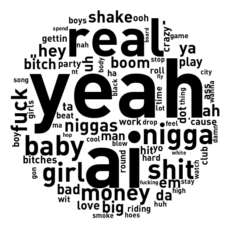

In [21]:
# vizualize one topic, we can use WordClouds:
import requests
import numpy as np
import matplotlib.pyplot as plt

from io import BytesIO
from PIL import Image
from wordcloud import WordCloud

TOPIC2PLOT = 1
MAX_WORDS = 80

def black_circle():
    response = requests.get('https://i.ibb.co/kHNWRYD/black-circle-better.png')
    circle_mask = np.array(Image.open(BytesIO(response.content)))
    return circle_mask 

circle_mask = black_circle()
wordcloud = WordCloud(background_color='#fff',
                      font_path='/content/gdrive/MyDrive/DIN Alternate Bold.otf',
                      color_func=lambda *args, **kwargs: (0,0,0),
                      mask=circle_mask)
wordcloud.generate_from_frequencies(frequencies=dict(spacy_lda.show_topic(TOPIC2PLOT, MAX_WORDS)))

plt.axis("off")
plt.imshow(wordcloud, interpolation="bilinear")

## Document topic distributions

### NLTK

In [ ]:
# get the topic distributions of each document
nltk_transformed_docs = nltk_lda.load_document_topics()

In [ ]:
#  loop over this iterator, we get the topic distributions for each document
import pandas as pd

nltk_transformed_docs = nltk_lda.load_document_topics()
nltk_topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in nltk_transformed_docs], 
             columns=['topic_{}'.format(i) for i in range(N_TOPICS)])
nltk_topic_distributions.head()

In [ ]:
# If we want to get the most prominent topics (i.e. the topics with the highest 
# average proportion) we can just use mean(), and then sort the values:
nltk_topic_distributions.mean().sort_values(ascending=False)

### Spacy

In [22]:
# get the topic distributions of each document
spacy_transformed_docs = spacy_lda.load_document_topics()

In [24]:
#  loop over this iterator, we get the topic distributions for each document
import pandas as pd

spacy_transformed_docs = spacy_lda.load_document_topics()
spacy_topic_distributions = pd.DataFrame([[x[1] for x in doc] for doc in spacy_transformed_docs], 
             columns=['topic_{}'.format(i) for i in range(N_TOPICS)])
spacy_topic_distributions.head()

,topic_0,topic_1
0,0.998758,0.001242
1,0.792851,0.207149
2,0.998065,0.001935
3,0.949049,0.050951
4,0.676615,0.323385


In [25]:
# If we want to get the most prominent topics (i.e. the topics with the highest 
# average proportion) we can just use mean(), and then sort the values:
spacy_topic_distributions.mean().sort_values(ascending=False)

topic_0    0.781716
topic_1    0.218284
dtype: float64

## Explore Using pyLDAvis

#### Imports

In [ ]:
import gensim

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

### NLTK

In [ ]:
pyLDAvis.enable_notebook()

nltk_lda_conv = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(nltk_lda)

gensimvis.prepare(nltk_lda_conv, nltk_corpus, nltk_dictionary)

### Spacy

In [28]:
pyLDAvis.enable_notebook()

spacy_lda_conv = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(spacy_lda)

gensimvis.prepare(spacy_lda_conv, spacy_corpus, spacy_dictionary)

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.198096  0.0       1        1  66.759611
1     -0.198096  0.0       2        1  33.240389, topic_info=       Term        Freq        Total Category  logprob  loglift
345      ai  657.000000   657.000000  Default  30.0000  30.0000
1984  nigga  376.000000   376.000000  Default  29.0000  29.0000
1009   shit  342.000000   342.000000  Default  28.0000  28.0000
804    real  485.000000   485.000000  Default  27.0000  27.0000
1053   fuck  290.000000   290.000000  Default  26.0000  26.0000
...     ...         ...          ...      ...      ...      ...
67        "  215.076325   414.040330   Topic2  -5.2529   0.4464
642     hit  139.799611   181.816854   Topic2  -5.6837   0.8386
92      man  179.230271   385.609084   Topic2  -5.4353   0.3353
220      ta  160.112375   428.281252   Topic2  -5.5481   0.1175
138    love  161.307244  2487.085244   Topic2  -5.5406  -1.6342

[199 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
67        1  0.480630       "
67        2  0.519273       "
286       1  0.395635       '
286       2  0.606177       '
0         1  0.750290  'cause
...     ...       ...     ...
66        1  0.045731      ya
66        2  0.952037      ya
234       1  0.497437    yeah
234       2  0.502853    yeah
1524      2  0.956471  yorker

[222 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

## Comparing Groups

In [38]:
metadata = df.copy()
metadata.head(3)

,Unnamed: 0,song_id,song,year,artist,genre,lyrics,video_path
0,0,104799,holy,2016,florida-georgia-line,Country,When the sun had left and the winter came And ...,https://www.youtube.com/watch?v=zXDAYlhdkyg
1,1,96856,temporary-home,2009,carrie-underwood,Country,Little boy six years old A little too used to ...,https://www.youtube.com/watch?v=LraOiHUltak
2,2,200403,pistol,2007,dustin-kensrue,Country,Love how you curse when I wake you up Sweetly ...,https://www.youtube.com/watch?v=72D49j0RcPs


### NLTK

In [ ]:
nltk_joined_topic_dist = metadata.reset_index().join(nltk_topic_distributions)
nltk_joined_topic_dist.head()

In [ ]:
nltk_grouped_by_genre = spacy_joined_topic_dist.groupby('genre').mean()
spacy_grouped_by_genre.head()

### Spacy

In [36]:
spacy_joined_topic_dist = metadata.reset_index().join(spacy_topic_distributions)
spacy_joined_topic_dist.head()

,index,Unnamed: 0,song_id,song,year,artist,genre,lyrics,video_path,topic_0,topic_1
0,0,0,104799,holy,2016,florida-georgia-line,Country,When the sun had left and the winter came And ...,https://www.youtube.com/watch?v=zXDAYlhdkyg,0.998758,0.001242
1,1,1,96856,temporary-home,2009,carrie-underwood,Country,Little boy six years old A little too used to ...,https://www.youtube.com/watch?v=LraOiHUltak,0.792851,0.207149
2,2,2,200403,pistol,2007,dustin-kensrue,Country,Love how you curse when I wake you up Sweetly ...,https://www.youtube.com/watch?v=72D49j0RcPs,0.998065,0.001935
3,3,3,81046,summer,2016,cassadee-pope,Country,Verse 1 Rolled in as wild and free As a clear ...,https://www.youtube.com/watch?v=4w5K75KPIcQ,0.949049,0.050951
4,4,4,78479,little-moments,2010,brad-paisley,Country,Well I'll never forget the first time that I h...,https://www.youtube.com/watch?v=vBErCVNP6rM,0.676615,0.323385


In [37]:
spacy_grouped_by_genre = spacy_joined_topic_dist.groupby('genre').mean()
spacy_grouped_by_genre.head()

,index,Unnamed: 0,song_id,year,topic_0,topic_1
genre,,,,,,
Country,240.320755,45654.849057,109181.943396,2008.698113,0.827711,0.172289
Electronic,310.210526,46663.971292,116755.866029,2009.727273,0.839825,0.160175
Folk,307.842105,44985.578947,129563.368421,2012.315789,0.937527,0.062473
Hip-Hop,417.737288,40199.932203,100414.271186,2009.084746,0.354986,0.645014
Indie,476.246988,47908.168675,124367.765060,2012.903614,0.924268,0.075732
